<a href="https://colab.research.google.com/github/tkalra11/PyTorch_FCC/blob/master/01_pytorch_workflow_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow

Steps :

1. Data prepration and loading
2. Building the model
3. Fitting the model
4. Making the predictions and evaluating the model
5. Saving and loading the model
6. Putting it all together

In [1]:
import torch
from torch import nn #torch.nn has PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.0.1+cu118'

## 1. Data prepration and loading

Types:
* Excel spreadsheet
* Images
* Videos
* Audios
* DNA
* Text

Basic parts of machine learning: 

1. Get data into a proper numerical represntation.
2. Build a model to learn the patterns in the numerical represntations.



Create some *known* data using the Linear Regression formula.

Formula :
The formula for a simple linear regression is:

y = $\beta$0  +  $\beta$1 X + $\epsilon$

* y is the predicted value of the dependent variable (y) for any given value of the independent variable (x).
* B0 is the intercept, the predicted value of y when the x is 0.
* B1 is the regression coefficient – how much we expect y to change as x increases.
* x is the independent variable ( the variable we expect is influencing y).
* e is the error of the estimate, or how much variation there is in our estimate of the regression coefficient.

We can use linear regression formula to make a straight line using *known* **parameters** (something that a machine learns)

In [3]:
# Creating the known parameters

weight = 0.7
bias = 0.3

# Create some data

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)

y = weight * X +bias

In [4]:
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X),len(y)

(50, 50)

### Splitting the dataset into 
1. Train data  ~ 60-80 %
2. Test data  ~ 10-20 %
3. Validation data  ~ 10-20 %


In [6]:
# Creating a train,test split

train_split = int(0.8 * len(X))

X_train , y_train = X[:train_split] , y[:train_split]

X_test , y_test = X[train_split:] , y[train_split:]

len(X_train) , len(y_train) ,len(X_test) , len(y_test)

(40, 40, 10, 10)

In [7]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None) :
                     """
                     Plots training and test data and compares the predictions.
                     """

                     plt.figure(figsize = (10,7))
                     
                     # Plotting the training data 
                     plt.scatter(train_data , train_labels , c='b', s=4 , label ="Training data")

                     # Plotting the test data
                     plt.scatter(test_data , test_labels , c='g' , s=4 , label ="Testing data")

                     # If there are predictions, plot the predictions
                     if predictions is not None:

                        #Plotting the predictions
                        plt.scatter(test_data , predictions , c='r' , s=4 , label = "Predictions")
                     plt.legend(prop = {"size" : 14 });

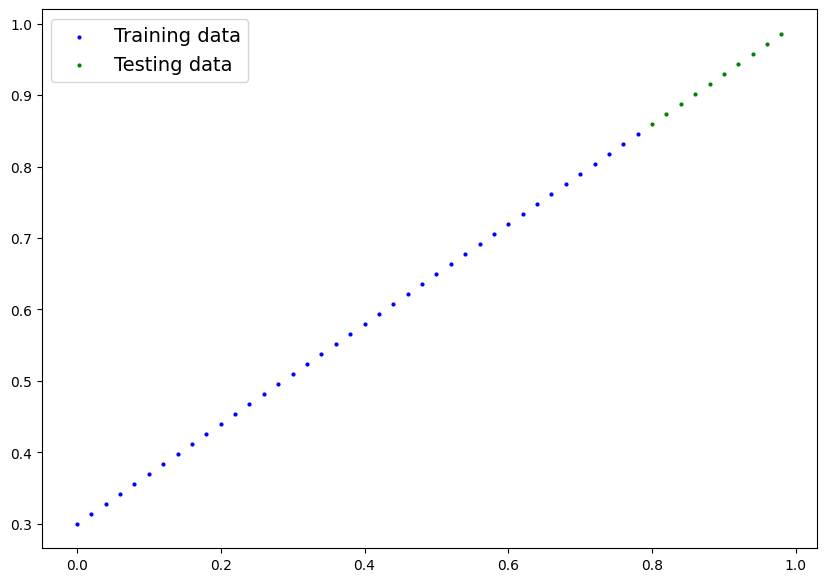

In [8]:
plot_predictions();

## 2. Build the model

First model in PyTorch.

Model functioning: 

* Start with random values of parameters (weights and bias)
* Use the training data to adjust the values of the parameters to better represent our data, and get closer to the ideal values

This happens through 2 main algorithms: 

1. Gradient descent -> https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropogation -> https://www.youtube.com/watch?v=tIeHLnjs5U8

In [9]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module):
    # Almost everything in PyTorch inherits a from nn.Module, Contains the building blocks for neural networks
    def __init__(self):
        super().__init__()

        #Initialize the model parameters
        self.weights = nn.Parameter(torch.randn(1,
                                                                        requires_grad = True,
                                                                        dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                                                        requires_grad = True,
                                                                        dtype = torch.float))
        
    # Forward method to define the computations in the model
    def forward(self , x : torch.Tensor) -> torch.Tensor :  # x is the input data Tensor
        return self.weights * x + self.bias

### PyTorch Model building essentials

* torch.nn - Basic building blocks for neural networks/computational graphs
* torch.Parameter - Parameters for model to try and learn, maybe set automatically by some layer.
* torch.nn.Module - Base class for nerual networks. If subclassing it, should overwrite forward()
* torch.optim - where optimizers in PyTorch live and help in gradient descent
* def forward() - All nn.Module subclasses require overwriting, defines what happens in forward computation

Cheat sheet -> https://pytorch.org/tutorials/beginner/ptcheat.html

### See whats inside the model

We can see our model parameters using `.parameters()`

In [10]:
# Creating the random seed
torch.manual_seed(42)

# Instance of the model

model_0 = LinearRegressionModel()

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [11]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

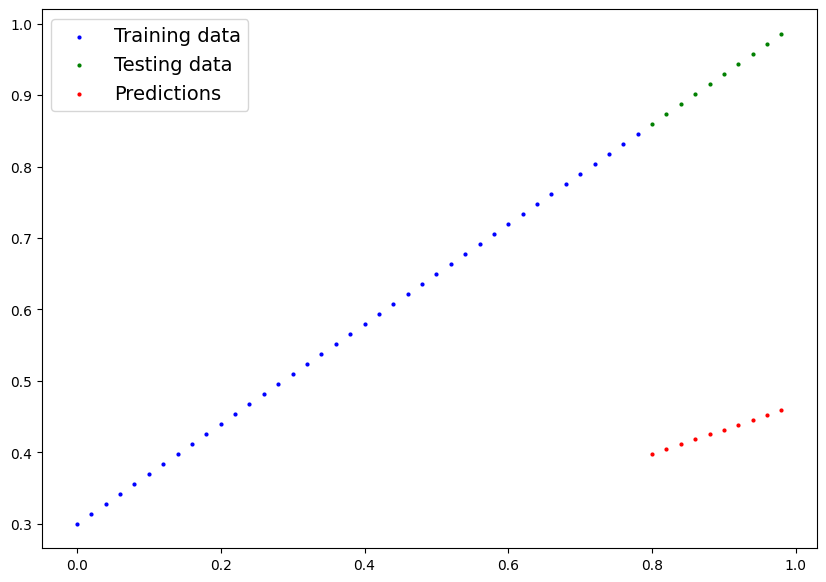

In [12]:
plot_predictions(predictions = y_preds)

## 3. Training the model - Fitting the model & Testing and Evaluation

While training the model we move from the *unknown* parameters to the ***known***parameters, i.e. from poor representation of the data to a better representation of the data.

One way to measure how the model is predicting is to use a loss function.

* Note: Loss function may also be called a cost function or a criterion in other areas of appliacations.

* **Loss Function:**  A function to measure how wrong your model's predictions are compared to the ideal outputs.
* **Optimizer:** Adjusts model parameters based on the loss of a model, in order to improve the loss.

For PyTorch specifically,we need: 
1. Training Loop
2. Testing Loop

In [13]:
# Setup a loss function

loss_fn = torch.nn.L1Loss()

In [14]:
# Setup an optimizer

optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.01)

### Building a training (and testing) loop

Requirements:
0. Loop through the data
1. Forward pass -> data through `forward()` 
2. Calculate the loss 
3. Optimize zero grad
4. Loss backward
5. Optimizer step

In [15]:
# An epoch is one loop through the data
epochs = 200

# Track experiments
epoch_count = []
loss_values = []
test_loss_values = []

# 0.  Loop through the data
for epoch in range(epochs) :
    # Set the model to training mode
    model_0.train() # sets all parameters that require gradients to require gradients
    
    #1. Forward pass
    y_pred = model_0(X_train)

    #2. Calculate the loss
    loss = loss_fn(y_pred,y_train)

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Step the optimizer
    optimizer.step()

    model_0.eval() #turns off settings not needed for evaluation/testing (dropout / batch norm /etc.)

    with torch.inference_mode(): # turns off gradient tracking
        #1. Forward pass
        test_pred = model_0(X_test)

        #2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)

    if ( epoch % 5 == 0):
        
        # Storing experiment values
        epoch_count.append(epoch)
        loss_values.append(loss.detach())
        test_loss_values.append(test_loss)

        print(f"Epoch : {epoch} | Loss : {loss} | Test Loss : {test_loss}")

Epoch : 0 | Loss : 0.31288138031959534 | Test Loss : 0.48106518387794495
Epoch : 5 | Loss : 0.2552763521671295 | Test Loss : 0.41371020674705505
Epoch : 10 | Loss : 0.1976713240146637 | Test Loss : 0.3463551998138428
Epoch : 15 | Loss : 0.14006635546684265 | Test Loss : 0.27900025248527527
Epoch : 20 | Loss : 0.08908725529909134 | Test Loss : 0.21729660034179688
Epoch : 25 | Loss : 0.06395438313484192 | Test Loss : 0.17353470623493195
Epoch : 30 | Loss : 0.053148526698350906 | Test Loss : 0.14464017748832703
Epoch : 35 | Loss : 0.04819351062178612 | Test Loss : 0.12584610283374786
Epoch : 40 | Loss : 0.04543796554207802 | Test Loss : 0.11360953003168106
Epoch : 45 | Loss : 0.04343796148896217 | Test Loss : 0.10470950603485107
Epoch : 50 | Loss : 0.04167863354086876 | Test Loss : 0.09919948130846024
Epoch : 55 | Loss : 0.039933640509843826 | Test Loss : 0.09368947893381119
Epoch : 60 | Loss : 0.03818932920694351 | Test Loss : 0.08886633068323135
Epoch : 65 | Loss : 0.03647511452436447 |

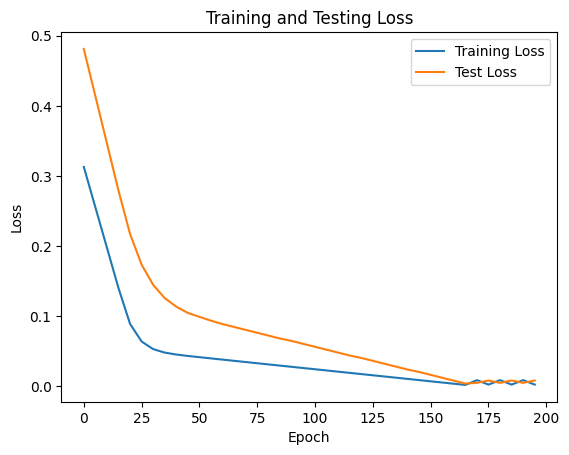

In [16]:
# Plot the losses
plt.plot(epoch_count , loss_values ,label = "Training Loss")
plt.plot(epoch_count , test_loss_values , label ="Test Loss")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [18]:
with torch.inference_mode(): # turns off gradient tracking
    y_preds_new = model_0(X_test)

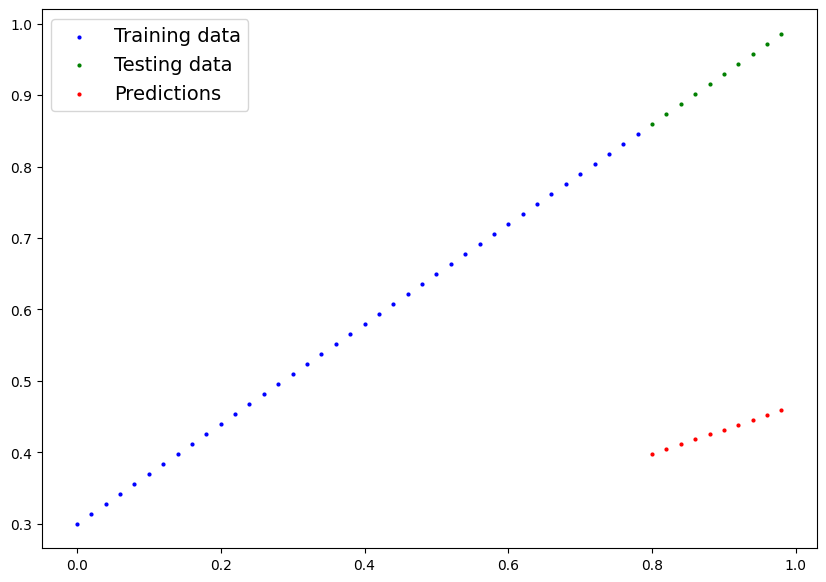

In [19]:
plot_predictions(predictions = y_preds)

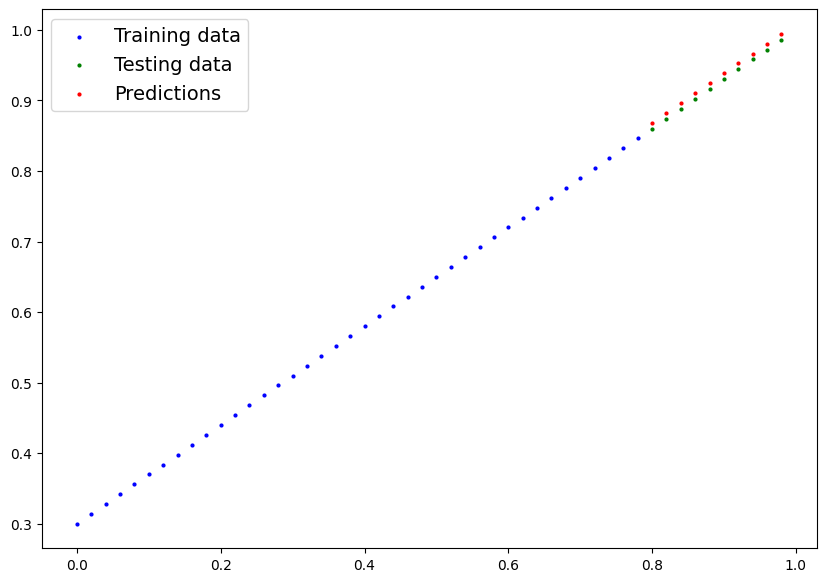

In [20]:
plot_predictions(predictions = y_preds_new)

## 5. Saving and loading the model

3 main methods for saving and loading the models:

1. `torch.save()` - PyTorch object in python's pickle object
2. `torch.load()` - load  a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary


https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html#saving-and-loading-models-for-inference-in-pytorch

### Saving the model

In [21]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True , exist_ok = True)

# Create a model save path
MODEL_NAME = "01_pytorch_workflow_run_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model to path : {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to path : models/01_pytorch_workflow_run_model_0.pth


In [22]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1223 May 31 20:46 01_pytorch_workflow_run_model_0.pth


### Loading the model

In [23]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [24]:
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH) )
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [26]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_pred = loaded_model_0(X_test)

In [27]:
# Compare the predictions

y_preds_new == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

### 6.1 Data

In [28]:
# Import libraries

import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.0.1+cu118'

Checing device agnostic code.

If we have access to GPU, we will use it, if not we will use CPU.

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using the device : {device}")

Using the device : cuda


In [30]:
!nvidia-smi

Wed May 31 20:46:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    14W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
# Creating the known parameters 

weight = 0.7
bias =0.3

# Creating the data

start = 0
end = 1
step = 0.02

# Create X and y

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = (weight * X + bias)

In [32]:
# Split the data
train_split = int(0.8 * len(X))
X_train , y_train = X[:train_split] , y[:train_split]
X_test , y_test = X[train_split:] , y[train_split:]

In [33]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None) :
                     """
                     Plots training and test data and compares the predictions.
                     """

                     plt.figure(figsize = (10,7))
                     
                     # Plotting the training data 
                     plt.scatter(train_data , train_labels , c='b', s=4 , label ="Training data")

                     # Plotting the test data
                     plt.scatter(test_data , test_labels , c='g' , s=4 , label ="Testing data")

                     # If there are predictions, plot the predictions
                     if predictions is not None:

                        #Plotting the predictions
                        plt.scatter(test_data , predictions , c='r' , s=4 , label = "Predictions")
                     plt.legend(prop = {"size" : 14 });

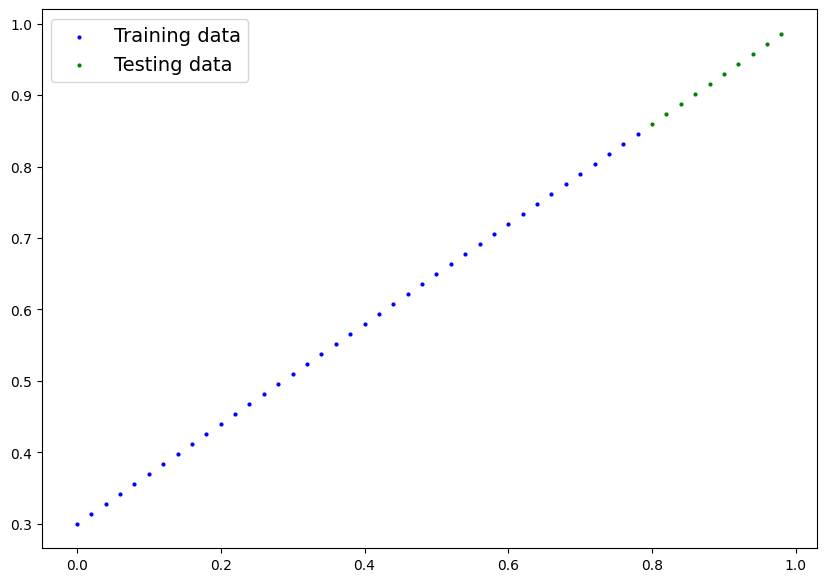

In [34]:
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Build the model

In [35]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        # Using PyTorch for the Linear model
        self.linear_layer = nn.Linear(in_features = 1,
                                      out_features = 1)
    
    def forward(self , x : torch.Tensor) -> torch.Tensor :
        return self.linear_layer(x)

In [36]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1 , model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [37]:
next(model_1.parameters()).device

device(type='cpu')

In [38]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training and testing the model

In [39]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01 )

In [40]:
torch.manual_seed(42)

epochs = 200

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

    model_1.train()

    y_preds = model_1(X_train)

    loss = loss_fn(y_preds,y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred,y_test)

    if epoch % 10 == 0:
        print(f"Epoch : {epoch} \t| Loss : {loss} \t\t| Test Loss : {test_loss}")

Epoch : 0 	| Loss : 0.5551779866218567 			| Test Loss : 0.5739762187004089
Epoch : 10 	| Loss : 0.439968079328537 			| Test Loss : 0.4392664134502411
Epoch : 20 	| Loss : 0.3247582018375397 			| Test Loss : 0.30455657839775085
Epoch : 30 	| Loss : 0.20954833924770355 			| Test Loss : 0.16984669864177704
Epoch : 40 	| Loss : 0.09433845430612564 			| Test Loss : 0.03513690456748009
Epoch : 50 	| Loss : 0.023886388167738914 			| Test Loss : 0.04784907028079033
Epoch : 60 	| Loss : 0.019956795498728752 			| Test Loss : 0.045803118497133255
Epoch : 70 	| Loss : 0.016517987474799156 			| Test Loss : 0.037530567497015
Epoch : 80 	| Loss : 0.013089174404740334 			| Test Loss : 0.02994490973651409
Epoch : 90 	| Loss : 0.009653178043663502 			| Test Loss : 0.02167237363755703
Epoch : 100 	| Loss : 0.006215683650225401 			| Test Loss : 0.014086711220443249
Epoch : 110 	| Loss : 0.00278724217787385 			| Test Loss : 0.005814164876937866
Epoch : 120 	| Loss : 0.0012645035749301314 			| Test Loss : 0

In [41]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Evaluating the model

In [42]:
model_1.eval()

with torch.inference_mode():
    y_preds_new = model_1(X_test)

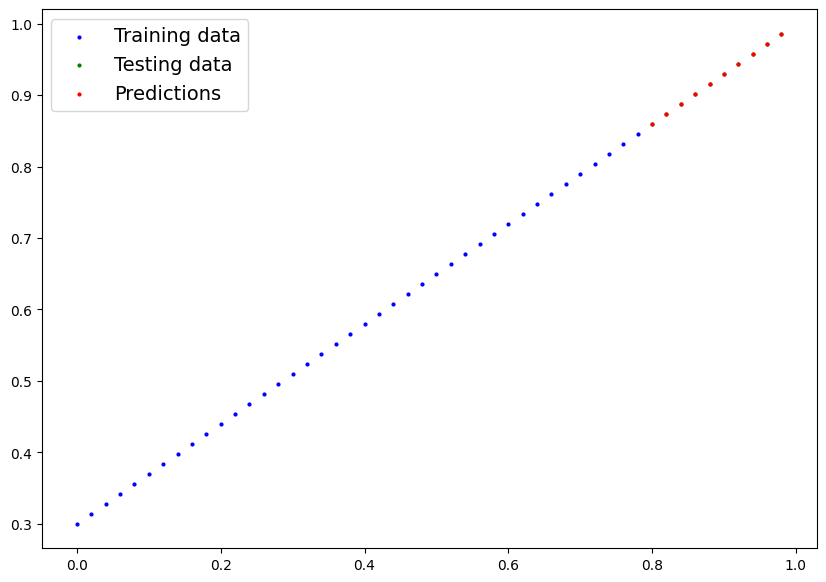

In [44]:
plot_predictions(predictions = y_preds_new.cpu())

### 6.5 Saving and loading the model

In [45]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True , exist_ok = True)

# Create a model save path
MODEL_NAME = "01_pytorch_workflow_run_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model to path : {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to path : models/01_pytorch_workflow_run_model_1.pth


In [48]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load( f = MODEL_SAVE_PATH))
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [49]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_preds = loaded_model_1(X_test)

y_preds_new == loaded_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')